In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Uncomment the following two lines every runtime
# !pip uninstall gensim
# !pip install gensim
from gensim.models import Word2Vec
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# Make sure using GPU throught "Edit-Notebook settings"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


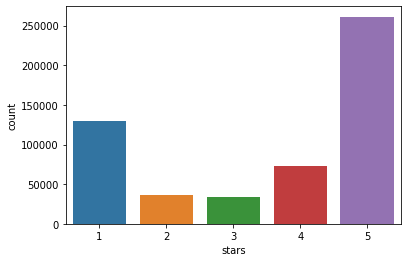

In [5]:
yelp = pd.read_json('/content/drive/MyDrive/cs182_proj/yelp_review_training_dataset.jsonl', lines=True)
yelp.head()
stars = yelp['stars'].values
ax = sns.countplot(x="stars",data=yelp)

In [8]:
yelp.shape

(533581, 3)

In [9]:
yelp[yelp.stars.notnull()]

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1
...,...,...,...
533576,2vQO_kmSr6YPBrR8GH_FPA,Dr Young and her assistants take obvious pride...,5
533577,DUdLTGVpgsi0sv_g4A5ITQ,We started our 20 month of daughter here on an...,5
533578,AKGELpRNTTXajuZHbPxdJg,"First of all, they are supposed to open at 9:0...",2
533579,ghYZM7lqzjej05I_T3vYyA,It's not often that you visit a company and th...,5


In [10]:
x_train = yelp['text'].values
x_train[0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [11]:
symbol = r'\w+|[^\s\w]+'
res = re.findall( symbol, x_train[0])
res

['Total',
 'bill',
 'for',
 'this',
 'horrible',
 'service',
 '?',
 'Over',
 '$',
 '8Gs',
 '.',
 'These',
 'crooks',
 'actually',
 'had',
 'the',
 'nerve',
 'to',
 'charge',
 'us',
 '$',
 '69',
 'for',
 '3',
 'pills',
 '.',
 'I',
 'checked',
 'online',
 'the',
 'pills',
 'can',
 'be',
 'had',
 'for',
 '19',
 'cents',
 'EACH',
 '!',
 'Avoid',
 'Hospital',
 'ERs',
 'at',
 'all',
 'costs',
 '.']

In [16]:
training = [re.findall( symbol, i) for i in x_train]
training = np.array(training)

In [18]:
training = list(training)
first_part = round(len(training) * 0.2)
print(first_part)

106716


In [19]:
self_model = Word2Vec(training[:first_part], min_count=1)
training_sample = [[self_model.wv.key_to_index[word] for word in sentence] for sentence in training[:first_part]]
self_model.wv.index_to_key[0]

In [23]:
y = np.array(stars[:first_part])
training_sample = np.array(training_sample)
train_x, val_x, train_y, val_y = train_test_split(training_sample, y, test_size=0.5, random_state=42)

In [25]:
maxlen = 200
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)

In [26]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.15):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.norm1 = layers.LayerNormalization(epsilon=1e-7)
        self.norm2 = layers.LayerNormalization(epsilon=1e-7)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        att1 = self.att(inputs, inputs)
        out1 = self.dropout1(att1, training=training)
        out1 = self.norm1(inputs + att1)
        out2 = self.ffn(out1)
        out2 = self.dropout2(out2, training=training)
        return self.norm2(out1 + out2)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
vocab_size = 200000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(ff_dim, activation="relu")(x)
x = layers.Dropout(0.15)(x)

# transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block2(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.15)(x)
# x = layers.Dense(ff_dim, activation="relu")(x)
# x = layers.Dropout(0.15)(x)

# transformer_block3 = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block3(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.15)(x)
# x = layers.Dense(32, activation="relu")(x)
# x = layers.Dropout(0.15)(x)

outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_x, train_y, batch_size=32, epochs=10, validation_data=(val_x, val_y)
)

Epoch 1/10
1668/1668 [==============================] - 434s 258ms/step - loss: 0.9256 - accuracy: 0.6493 - val_loss: 0.6748 - val_accuracy: 0.7412
Epoch 2/10
1668/1668 [==============================] - 428s 256ms/step - loss: 0.5734 - accuracy: 0.7738 - val_loss: 0.7005 - val_accuracy: 0.7361
Epoch 3/10
1668/1668 [==============================] - 426s 256ms/step - loss: 0.4426 - accuracy: 0.8271 - val_loss: 0.7852 - val_accuracy: 0.7209
Epoch 4/10
1668/1668 [==============================] - 426s 255ms/step - loss: 0.3479 - accuracy: 0.8677 - val_loss: 1.0658 - val_accuracy: 0.7075
Epoch 5/10
1668/1668 [==============================] - 428s 257ms/step - loss: 0.2635 - accuracy: 0.9011 - val_loss: 1.1349 - val_accuracy: 0.6992
Epoch 6/10
1668/1668 [==============================] - 429s 257ms/step - loss: 0.2072 - accuracy: 0.9235 - val_loss: 1.4202 - val_accuracy: 0.6929
Epoch 7/10
1668/1668 [==============================] - 430s 258ms/step - loss: 0.1544 - accuracy: 0.9443 - val_